# Notebook Preamble

## IPython Magic

In [1]:
%load_ext autoreload
%autoreload 3

## Notebook Imports

In [2]:
# 3rd Party Imports:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import matplotx
import duckdb
import polars as pl
import dagster as dg
from dagster import AssetKey
from pathlib import Path
import os

In [3]:
# PUDL Imports
import pudl
from pudl.etl import defs
from pudl.workspace.setup import PudlPaths

In [4]:
logger = pudl.logging_helpers.get_logger("pudl")
os.environ["PUDL_INPUT"]

'/Users/zane/code/catalyst/pudl-input'

## Visualization Settings

In [5]:
%matplotlib inline

In [6]:
matplotlib.rcParams["figure.figsize"] = (10, 6)
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.style.use(matplotx.styles.onedark)

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_colwidth", 1000)

pl.Config.set_tbl_rows(500)
pl.Config.set_tbl_cols(100)
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

## Set up data access shortcuts

In [7]:
from pudl.helpers import get_parquet_table as get_parquet
import geopandas as gpd

def get_asset(table: str) -> pd.DataFrame | gpd.GeoDataFrame:
    return defs.load_asset_value(AssetKey(table))

def get_pandas(table: str) -> pd.DataFrame:
    return pd.read_parquet(
        Path(os.environ["PUDL_OUTPUT"]) / f"parquet/{table}.parquet",
        memory_map=True,
        engine="pyarrow",
    ).convert_dtypes()

def get_polars(table: str) -> pl.DataFrame:
    return pl.read_parquet(
        Path(os.environ["PUDL_OUTPUT"]) / f"parquet/{table}.parquet",
    )

def get_pyarrow(table: str) -> pd.DataFrame:
    return pd.read_parquet(
        Path(os.environ["PUDL_OUTPUT"]) / f"parquet/{table}.parquet",
        dtype_backend="pyarrow",
        memory_map=True,
        engine="pyarrow",
    )


In [8]:
companies = get_polars("out_sec10k__quarterly_company_information")
filings = get_polars("out_sec10k__quarterly_filings")
parsubs = get_polars("out_sec10k__parents_and_subsidiaries")
name_changes = get_polars("out_sec10k__changelog_company_name")
ex21 = get_polars("core_sec10k__quarterly_exhibit_21_company_ownership")

## What fraction of electricity companies are linked to EIA utilities?

### Identify industry IDs with lots of Utility ID associations

- This is kind of begging the question, but it's not a terrible way to find interesting SICs to look at.
- Unsurprisingly the two top SICs with the largest number of Utility ID associations are electric services, and electric & other services combined (many seem to be combined electric & gas utilities)
- There's also a number of "real estate" oriented industries. Maybe they have big behind-the-meter C&I solar installations?
- There are also a number of industries that typically engage in cogeneration, especially papermills, oil & gas, natural gas transmission companies, etc.
- Filtering all the industry names for "electric" and "power" shows a bunch of other industries that are not related to electricity generation. Mostly electronics, etc.
- So the 4911 and 4931 seem to be the main ones we expect to link to EIA Utilities.
- And then there's a number of smaller industries with cogeneration that often match, but don't have as many companies in them, and probably aren't responsible for much generation.
- Note: this kind of analysis would be easier if we cleaned up the SIC names & IDs so that they're more consistent & complete.

In [9]:
(
    get_polars("out_sec10k__quarterly_company_information")
    .filter(pl.col("utility_id_eia").is_not_null())
    .select(["industry_id_sic", "industry_name_sic"])
    .group_by(["industry_id_sic", "industry_name_sic"])
    .agg(count=pl.len())
    .sort("count", descending=True)
    .head(20)
)

industry_id_sic,industry_name_sic,count
str,str,u32
"""4911""","""electric services""",6661
"""4931""","""electric & other services combined""",2041
"""6798""","""real estate investment trusts""",402
"""6189""","""asset-backed securities""",368
"""4911""",null,228
"""1311""","""crude petroleum & natural gas""",222
"""2621""","""paper mills""",174
"""2834""","""pharmaceutical preparations""",173
null,null,135


In [10]:
electricity_sics = (
    get_polars("out_sec10k__quarterly_company_information")
    .group_by(sic=pl.col("industry_id_sic"))
    .agg(
        fraction_with_utility_id=pl.col("utility_id_eia").is_not_null().mean()
    )
    .sort("fraction_with_utility_id", descending=True)
    .head(20)
    #.filter(pl.col("fraction_with_utility_id") > 0.50)
    #.select("sic").to_series().to_list()
)
electricity_sics

sic,fraction_with_utility_id
str,f64
"""4911""",0.584408
"""2631""",0.542601
"""4991""",0.542017
"""4931""",0.51861
"""2621""",0.406181
"""2600""",0.4
"""2650""",0.34375
"""3011""",0.269565
"""3760""",0.267516


In [11]:
majority_electric = electricity_sics.filter(pl.col("fraction_with_utility_id") > 0.5).select("sic").to_series().to_list()
(
    get_polars("out_sec10k__quarterly_company_information")
    .filter(pl.col("industry_id_sic").is_in(majority_electric))
    .select(["industry_id_sic", "industry_name_sic"])
    .group_by(["industry_id_sic", "industry_name_sic"])
    .agg(count=pl.len())
    .sort("count", descending=True)
)

industry_id_sic,industry_name_sic,count
str,str,u32
"""4911""","""electric services""",11368
"""4931""","""electric & other services combined""",3941
"""4911""",null,420
"""4991""","""cogeneration services & small power producers""",233
"""2631""","""paperboard mills""",209
"""4931""",null,116
"""2631""",null,14
"""4991""",null,5


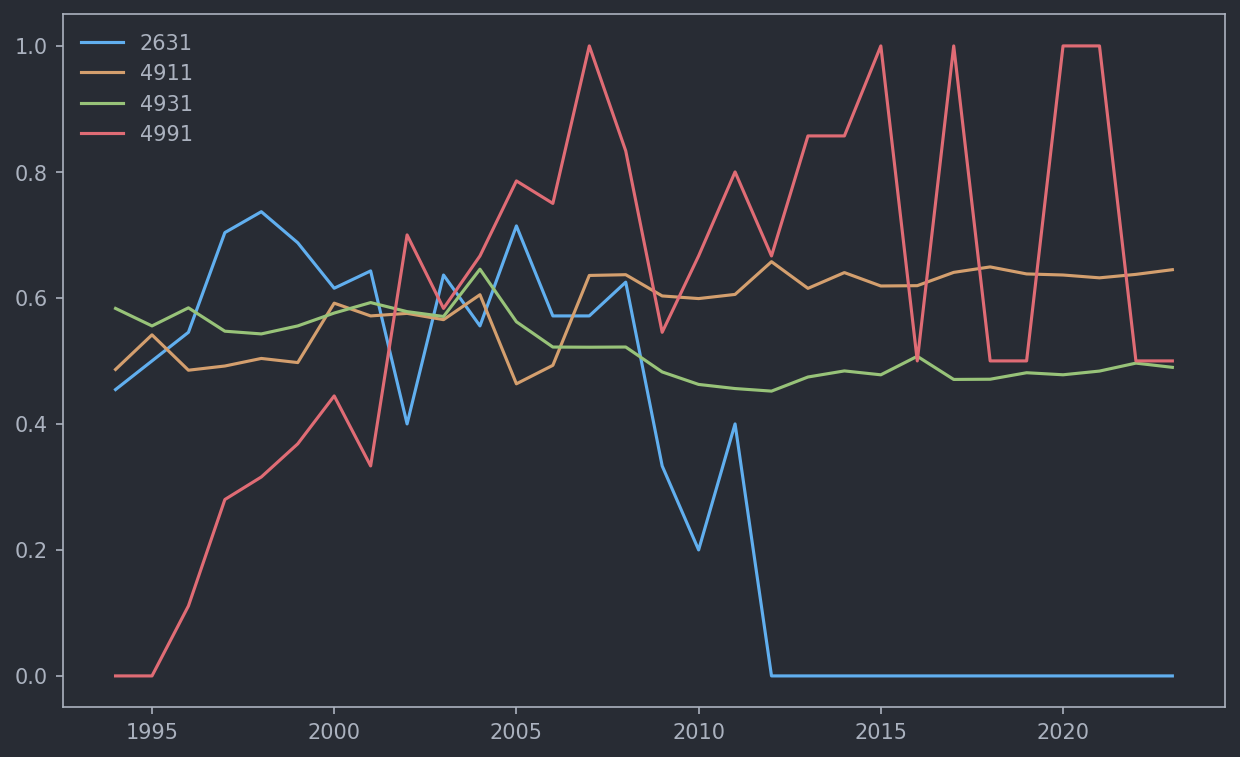

In [12]:
util_ids_by_year = get_polars("out_sec10k__quarterly_company_information").filter(
    pl.col("industry_id_sic").is_in(majority_electric),
).with_columns(
    year=pl.col("report_date").dt.year()
).group_by(["year", "industry_id_sic"]).agg(
    fraction_with_utility_id=pl.col("utility_id_eia").is_not_null().mean(),
).sort("year")

for sic in util_ids_by_year["industry_id_sic"].unique():
    df = util_ids_by_year.filter(pl.col("industry_id_sic") == sic)
    plt.plot(df["year"], df["fraction_with_utility_id"], label=sic)

plt.legend()

## What SEC electric companies aren't we matching to EIA?

- Selecting just companies in the main electric industry SICs, who are they?
- They make up 40-50% of all the electric companies.
- Many of them look like familiar entities that we'd expect to find in EIA.

In [13]:
unmatched_companies = (
    get_polars("out_sec10k__quarterly_company_information")
    .filter(
        pl.col("industry_id_sic").is_in(["4911", "4931"]),
        pl.col("utility_id_eia").is_null(),
    )
    .select(["central_index_key", "company_name", "report_date"])
    .unique(["central_index_key", "company_name", "report_date"])
)
unmatched_companies.sample(30).sort("report_date")

central_index_key,company_name,report_date
str,str,date
"""0000315256""","""public service co of new hampshire""",1998-01-01
"""0000081023""","""public service co of new mexico""",1998-01-01
"""0001012127""","""baycorp holdings ltd""",1999-01-01
"""0000741612""","""tnp enterprises inc""",2000-01-01
"""0000060527""","""entergy louisiana inc""",2002-01-01
"""0001089206""","""pseg energy holdings llc""",2003-01-01
"""0000754737""","""scana corp""",2003-04-01
"""0001124468""","""nrg south central generating llc""",2003-04-01
"""0000350563""","""teco energy inc""",2004-04-01


## How does matching to EIA vary by year?

* The SEC data goes back further than the EIA data, so we'd probably expect the older years to have more unmatched companies.
* This does generally seem to be the case, with ~2x as many unmatched companies in the early 2000s compared to more recent years.

<BarContainer object of 30 artists>

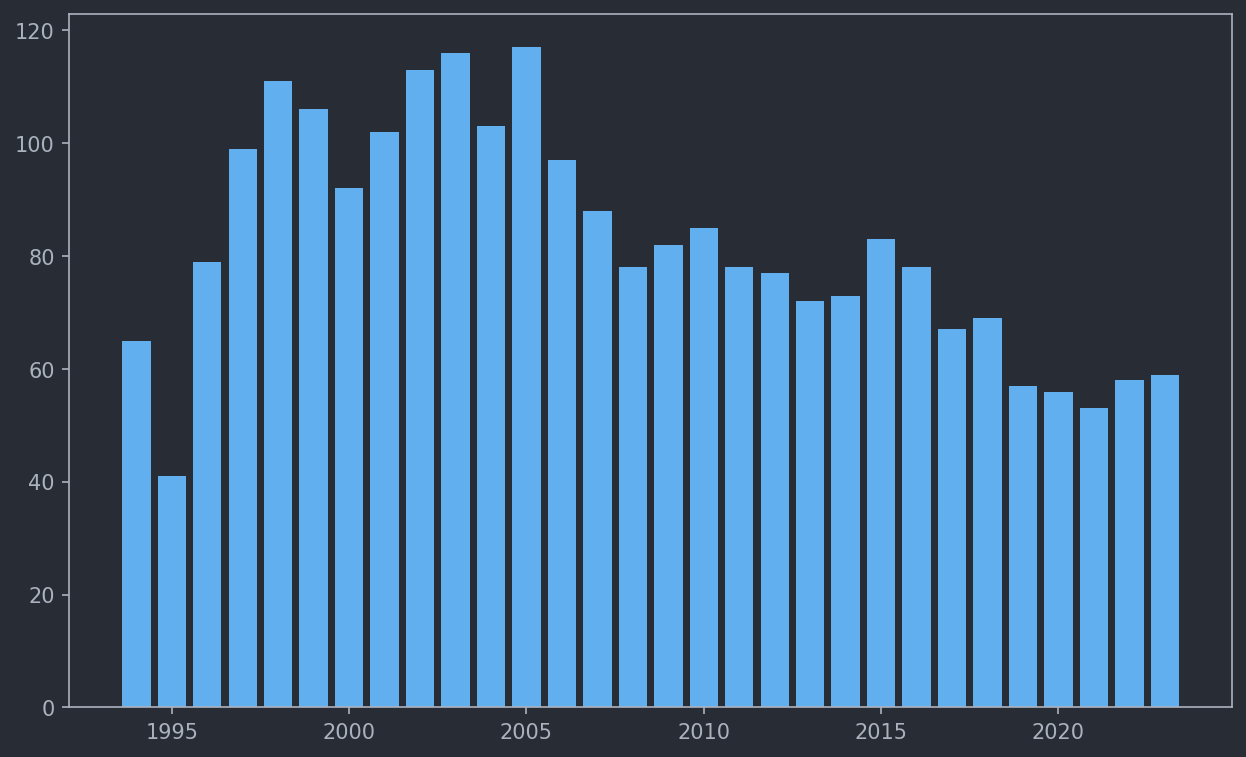

In [14]:
unmatched_by_year = (
    unmatched_companies.group_by(
        pl.col("report_date").dt.year()
    ).agg(count=pl.len())
    .sort("report_date")
)
plt.bar(unmatched_by_year["report_date"], unmatched_by_year["count"])

# SEC 10-K Filer to Subsidiary matches

* How successful are we at matching subsidiary companies to a corresponding SEC 10-K filer?
* Does this vary over time?

## Number of parent-subsidiary relations per year
* Roughly linear increase up until 2017.
* Gap due to failed extraction of Q1 Ex21 data for 2018-2022.
* Interestingly 2023 is about the same as 2015-2017 so did the linear trend in the increase in number of subsidiaries end?

<BarContainer object of 31 artists>

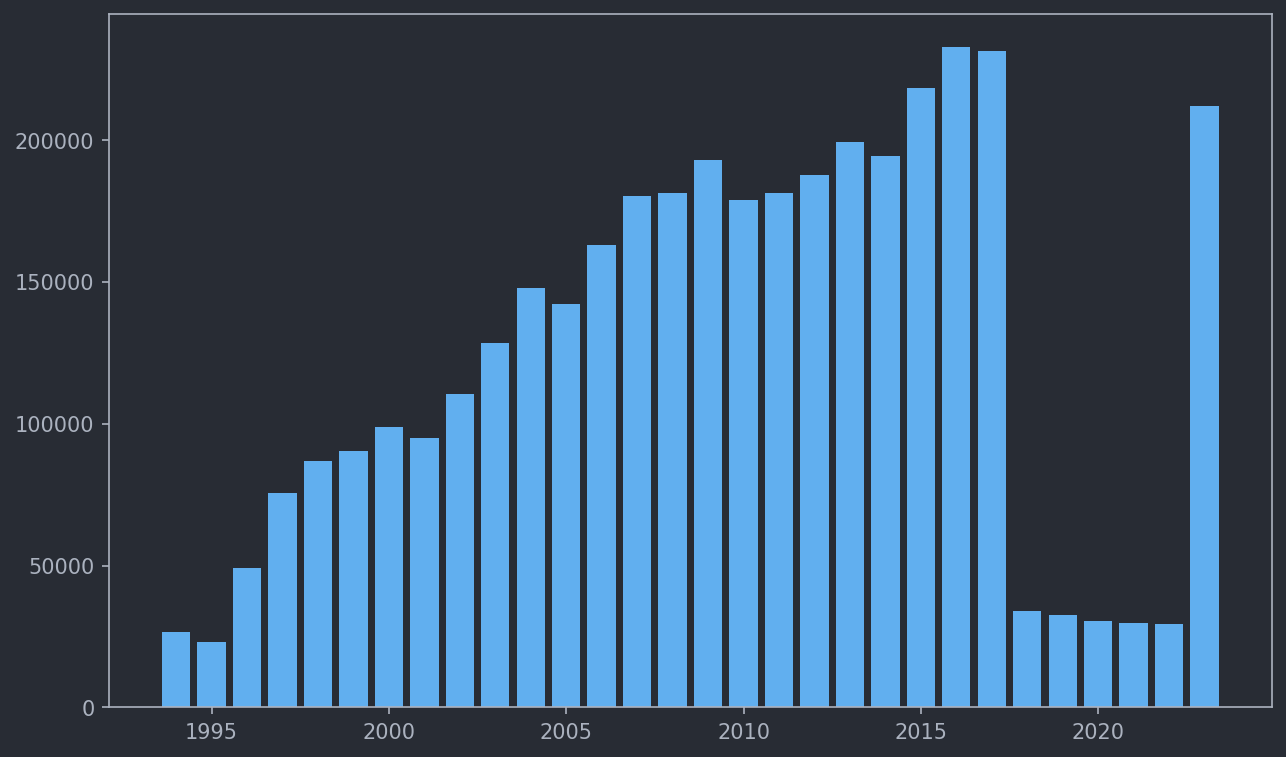

In [15]:
parsubs_by_year = (
    get_polars("out_sec10k__parents_and_subsidiaries")[
        "report_date",
        "parent_company_central_index_key",
        "parent_company_utility_id_eia",
        "parent_company_name",
        "subsidiary_company_id_sec10k",
        "subsidiary_company_central_index_key",
        "subsidiary_company_utility_id_eia",
        "subsidiary_company_name",
        "fraction_owned",
    ].group_by(
        report_year=pl.col("report_date").dt.year()
    ).agg(
        count=pl.len()).sort("report_year")
)
plt.bar(parsubs_by_year["report_year"], parsubs_by_year["count"])

## Subsidiary to Filer match rate over time
* Has the proportion of subsidiary companies matched to some SEC 10-K filer changed over time?
* This is entirely within the SEC 10-K dataset, so the change in EIA data availability should have no impact.
* The match rate is quite low across the board. Only 1-4% of all subsidiaries can be matched to an SEC filer.
* Since 2012, the rate has been more stable, but low, around 1%.

<BarContainer object of 31 artists>

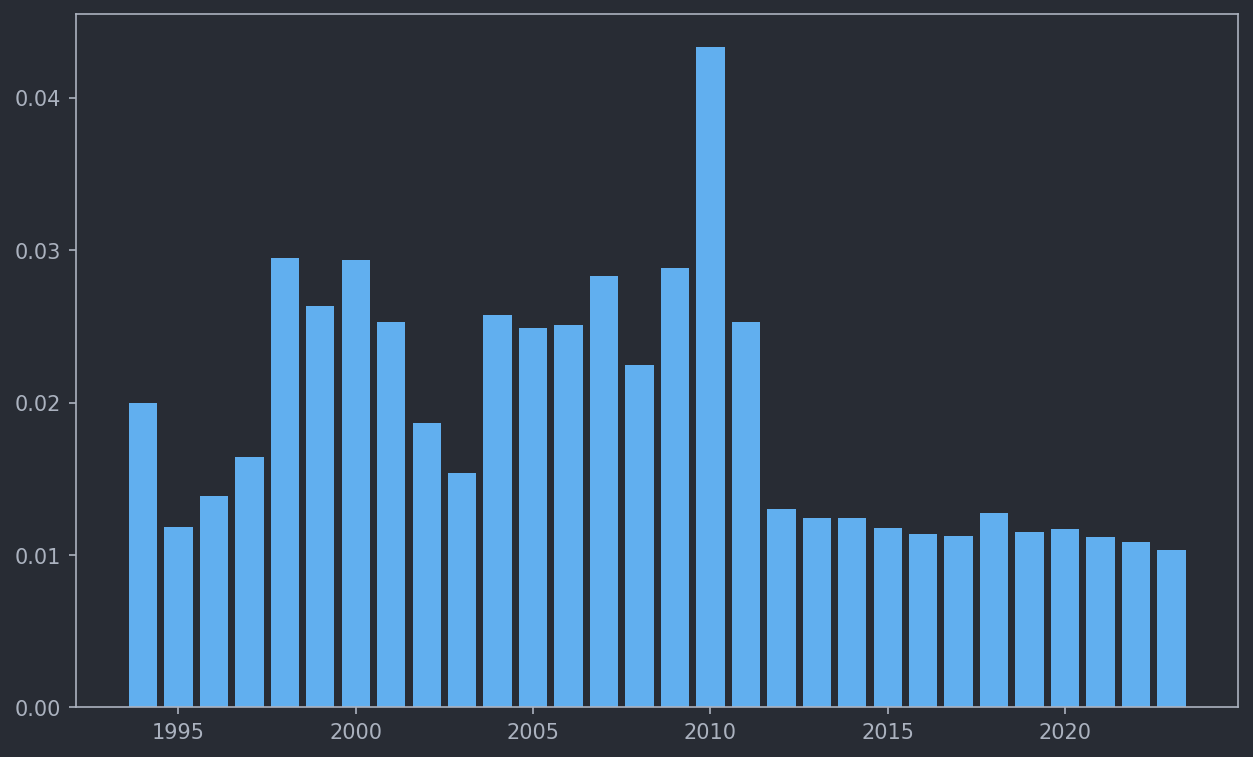

In [16]:
sub_match_rate_by_year = (
    get_polars("out_sec10k__parents_and_subsidiaries")
    .group_by(report_year=pl.col("report_date").dt.year())
    .agg(
        sub_match_rate=pl.col("subsidiary_company_central_index_key").is_not_null().mean(),
    )
)
plt.bar(sub_match_rate_by_year["report_year"], sub_match_rate_by_year["sub_match_rate"])

## Match rates for electricity companies
* Maybe the match rate is different for the electricity oriented companies?
* Since only companies of a certain size have to report, industries with a larger minimum company size seem like they might have higher match rates.
* This seems to be the case, with match rates between 4-10%.
* However, we get no matches for electricity companies in the 2018-2022 gap.


<BarContainer object of 30 artists>

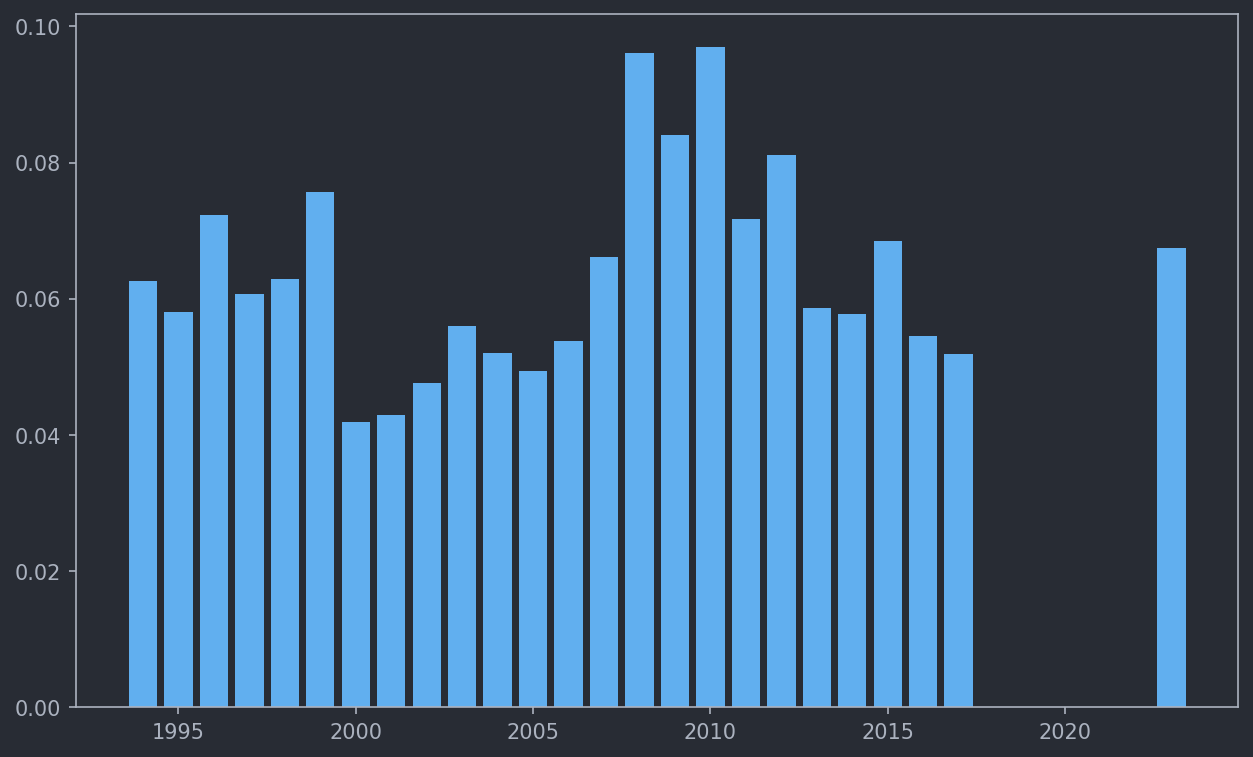

In [17]:
electrosub_match_rate_by_year = (
    get_polars("out_sec10k__parents_and_subsidiaries")
    .filter(pl.col("parent_company_industry_id_sic").is_in(["4911", "4931"]))
    .group_by(report_year=pl.col("report_date").dt.year())
    .agg(
        electrosub_match_rate=pl.col("subsidiary_company_central_index_key").is_not_null().mean(),
    )
)
plt.bar(electrosub_match_rate_by_year["report_year"], electrosub_match_rate_by_year["electrosub_match_rate"])

## How do subsidiary matches evolve over time?

* To get a qualitative sense of how matches change over time, let's look at a familiar parent company with known subsidiaries, Xcel Energy.
* Here we look at a sample of years (2001, 2012, 2023) across the range of available years.
* Across these years there are 5 distinct subsidiaries that have gotten SICs over the years.
* In 2001 NRG Energy is a subsidiary of Xcel, but [it is later sold off](https://en.wikipedia.org/wiki/NRG_Energy).
* Public Service Company of Colorado (PSCo) and Southwestern Public Service Company (New Mexico) are successfully captured across the whole sample.
* The two other upper-midwest subsidiaries (North States Power MN and WI) are captured in the latter years, but are captured with a differen string in 2001 and so get missed.
* So we know the subsidiary company IDs can change over time, even within the reporting of a single parent company, and that this affects the intra-SEC matching.
* This is in addition to the subsidary IDs necessarily varying between parent companies, since the ID incorporates the parent's CIK as part of the ID.
* There also seem to be dozens of other Xcel subsidiaries that we've never heard of that never get a CIK. Searching for "xcel" in the company information table they don't show up, so it seems likely they truly aren't filers.
* Interestingly, there is only one Xcel subsidiary that ever shows up here with a Utility ID EIA, and it's not any of the ones that get CIKs.
* None of the subsidiaries have any ownership fraction reported. I think Xcel completely owns PSCo and SWPS, so I wonder how often NA really means 1.0?


In [18]:
(
    get_polars("out_sec10k__parents_and_subsidiaries")[
        "report_date",
        "parent_company_central_index_key",
        "parent_company_utility_id_eia",
        "parent_company_name",
        "subsidiary_company_id_sec10k",
        "subsidiary_company_central_index_key",
        "subsidiary_company_utility_id_eia",
        "subsidiary_company_name",
        "fraction_owned",
    ].filter(
        pl.col("report_date").dt.year().is_in([2001, 2012, 2023]),
        pl.col("parent_company_central_index_key").eq("0000072903")
    ).sort("report_date")
)

report_date,parent_company_central_index_key,parent_company_utility_id_eia,parent_company_name,subsidiary_company_id_sec10k,subsidiary_company_central_index_key,subsidiary_company_utility_id_eia,subsidiary_company_name,fraction_owned
date,str,i32,str,str,str,i32,str,f32
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_black mountain gas company_minnesota""",null,null,"""black mountain gas company""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_cheyenne light, fuel and power company_wyoming""",null,null,"""cheyenne light, fuel and power company""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_e prime, inc_colorado""",null,null,"""e prime, inc""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_eloigne company_minnesota""",null,null,"""eloigne company""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_northern states power company (minnesota_minnesota""",null,null,"""northern states power company (minnesota""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_northern states power company (wisconsin_wisconsin""",null,13780,"""northern states power company (wisconsin""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_nrg energy, inc_delaware""","""0001013871""",null,"""nrg energy, inc""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_planergy international inc_texas""",null,null,"""planergy international inc""",null
2001-01-01,"""0000072903""",56149,"""xcel energy inc""","""0000072903_public service company of colorado_colorado""","""0000081018""",null,"""public service company of colorado""",null


## Other Xcel subsidiaries?
* The other baby Xcels really don't seem to show up as filers.

In [19]:
(
    get_polars("out_sec10k__quarterly_company_information")
    .filter(
        pl.col("company_name").str.contains("^[xX]cel")
    )["company_name"]
    .unique()
)

company_name
str
"""xcellenet inc /ga/"""
"""xcellink international inc."""
"""xcel energy inc"""
"""xcel brands, inc."""
"""xcelmobility inc."""


## Nested inside a non-utility
* Another kind of example: utility companies that are hidden inside a non-utility.
* Berkshire Hathaway is a sprawling conglomerate that owns a bunch of different kinds of companies, including utility companies like PacifiCorp.
* The ur-parent is Berkshire Hathaway Inc, and it has an energy focused subsidiary Berkshire Hathaway Energy, which itself reports having a bunch of energy subsidiaries.
* Most (all?) energy subsidiaries seem to appear in the Ex21 data for both Berkshire Hathaway and Berkshire Hathaway Energy.
* Midamerican Energy Co shows up in both, and is assigned the same CIK in both, has the same name in both, but only gets an EIA Utility ID in association with BHE, which seems surprising.

In [20]:
(
    get_polars("out_sec10k__parents_and_subsidiaries")[
        "report_date",
        "parent_company_central_index_key",
        "parent_company_utility_id_eia",
        "parent_company_name",
        "subsidiary_company_id_sec10k",
        "subsidiary_company_central_index_key",
        "subsidiary_company_utility_id_eia",
        "subsidiary_company_name",
        "fraction_owned",
    ].filter(
        pl.col("report_date").dt.year().is_in([2023]),
        pl.col("parent_company_name").str.contains("berkshire.*hathaway"),
    ).sort("report_date")
)

report_date,parent_company_central_index_key,parent_company_utility_id_eia,parent_company_name,subsidiary_company_id_sec10k,subsidiary_company_central_index_key,subsidiary_company_utility_id_eia,subsidiary_company_name,fraction_owned
date,str,i32,str,str,str,i32,str,f32
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_21st mortgage corporation_delaware""",null,null,"""21st mortgage corporation""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_acme brick company_delaware""",null,null,"""acme brick company""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_acme building brands, inc_delaware""",null,null,"""acme building brands, inc""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_affordable housing partners, inc_delaware""",null,null,"""affordable housing partners, inc""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_aihl re llc_vermont""",null,null,"""aihl re llc""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_albecca inc_georgia""","""0001061777""",null,"""albecca inc""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_alleghany capital corporation_delaware""",null,null,"""alleghany capital corporation""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_alleghany corporation_delaware""",null,null,"""alleghany corporation""",null
2023-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_alleghany insurance holdings llc_delaware""",null,null,"""alleghany insurance holdings llc""",null


## More subsidiaries over time
* Just looking at subsidiaries of BH/BHE that seem to be associated with NV Energy, which sometimes shows up as nevada power company aand sometimes sierra pacific power company.
* "nevada power company" and "sierra pacific power company" both have EIA utility IDs in 2023, but no previous year.
* All the "d/b/a nv energy" subsidiary name records fail to get associated with a CIK.
* The d/b/a records all seem to be associated with BHE, and the same subsidiaries are reported under Berkshire Hathaway as well.
* This is a concrete example of the same subsidiary having different "names" under different parent companies, even when they're both under the same bigger parent company.
* In the most recent year of data nevada power and sierra pacific stop using the "d/b/a" naming, creating a discontinuity in the naming across time as well as between reporting parent companies.

In [21]:
(
    get_polars("out_sec10k__parents_and_subsidiaries")[
        "report_date",
        "parent_company_central_index_key",
        "parent_company_utility_id_eia",
        "parent_company_name",
        "subsidiary_company_id_sec10k",
        "subsidiary_company_central_index_key",
        "subsidiary_company_utility_id_eia",
        "subsidiary_company_name",
        "fraction_owned",
    ].filter(
        pl.col("parent_company_name").str.contains("berkshire.*hathaway"),
        pl.col("subsidiary_company_name").str.contains("(nv |nevada|sierra)")
        #pl.col("parent_company_central_index_key").eq("0001081316"),
        #pl.col("subsidiary_company_central_index_key").is_not_null() | pl.col("subsidiary_company_utility_id_eia").is_not_null(),
    ).sort("report_date")
)

report_date,parent_company_central_index_key,parent_company_utility_id_eia,parent_company_name,subsidiary_company_id_sec10k,subsidiary_company_central_index_key,subsidiary_company_utility_id_eia,subsidiary_company_name,fraction_owned
date,str,i32,str,str,str,i32,str,f32
2015-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_nevada power company_nevada""","""0000071180""",null,"""nevada power company""",null
2015-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_nv energy, inc_nevada""","""0000741508""",null,"""nv energy, inc""",null
2015-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_sierra pacific power company_nevada""","""0000090144""",null,"""sierra pacific power company""",null
2015-01-01,"""0001081316""",null,"""berkshire hathaway energy co""","""0001081316_nevada power company d/b/a nv energy_nevada""",null,null,"""nevada power company d/b/a nv energy""",null
2015-01-01,"""0001081316""",null,"""berkshire hathaway energy co""","""0001081316_nv energy, inc_nevada""","""0000741508""",null,"""nv energy, inc""",null
2015-01-01,"""0001081316""",null,"""berkshire hathaway energy co""","""0001081316_sierra pacific power company d/b/a nv energy_nevada""",null,null,"""sierra pacific power company d/b/a nv energy""",null
2016-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_nevada power company_nevada""","""0000071180""",null,"""nevada power company""",null
2016-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_nv energy, inc_nevada""","""0000741508""",null,"""nv energy, inc""",null
2016-01-01,"""0001067983""",null,"""berkshire hathaway inc""","""0001067983_sierra pacific power company_nevada""","""0000090144""",null,"""sierra pacific power company""",null


## How common are (electricity) subsidiaries with utility IDs?
* Above we've seen a couple of examples where a subisidiary with the same name & location across multiple years doesn't always get assigned an EIA Utility ID.
* In this small sample it seems like utility IDs are more commonly assigned in the most recent year. What does that distribution look like?
* The fraction of subsidiary companies that have utility IDs seems to increase linearly over time, from just a couple of percent to nearly 20%.
* This is on top of the absolute **number** of subsidiaries increasing linearly over time.

<BarContainer object of 30 artists>

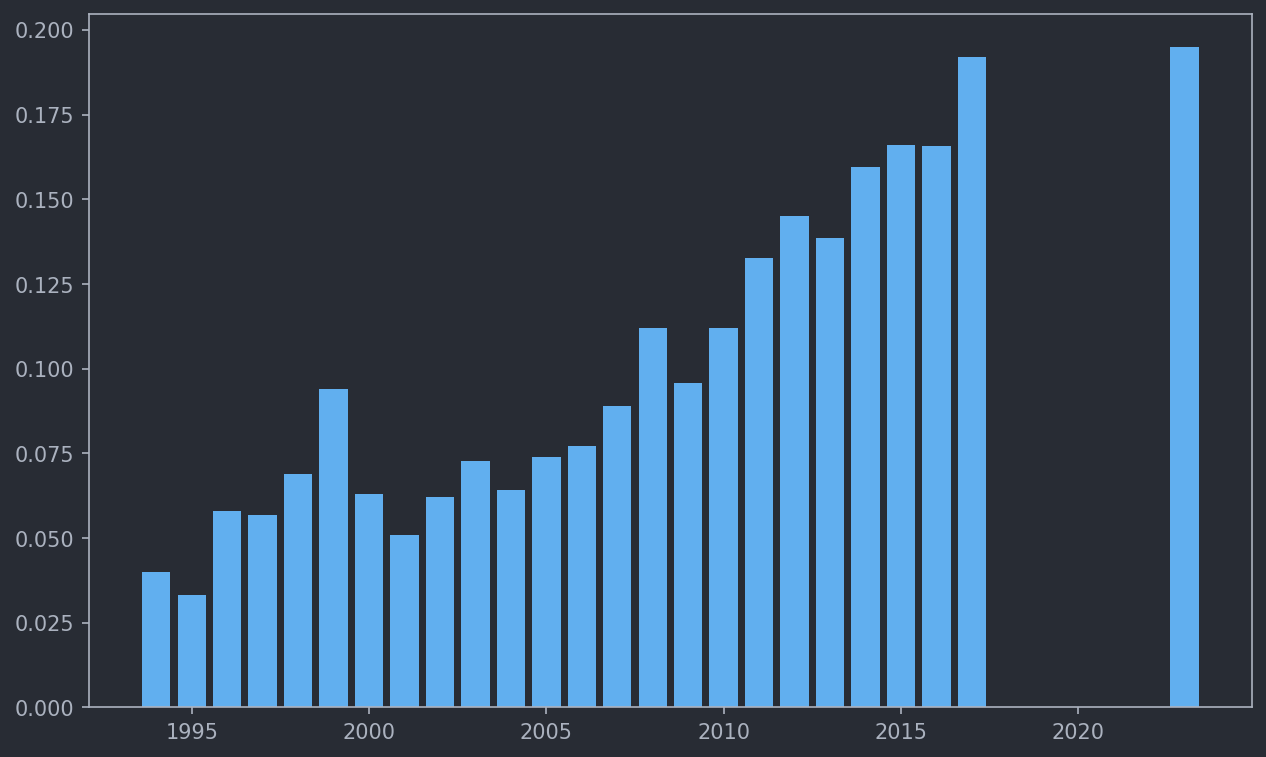

In [22]:
electrosub_has_utility_id = (
    get_polars("out_sec10k__parents_and_subsidiaries")
    .filter(
        pl.col("parent_company_industry_id_sic").is_in(["4911", "4931"])
        | pl.col("subsidiary_company_industry_id_sic").is_in(["4911", "4931"])
    )
    .group_by(year=pl.col("report_date").dt.year())
    .agg(has_utility_id_eia=pl.col("subsidiary_company_utility_id_eia").is_not_null().mean())
    .sort("year")
)
plt.bar(electrosub_has_utility_id["year"], electrosub_has_utility_id["has_utility_id_eia"])